# Calculate permeability of sand-clay mixtures

Calculate permeability of sediment mixtures (ie mixtures of clay and granular material (sand, silt) and compare with emasured values. The calculation of permeability uses a series of equations by Luijendijk and Gleeson (2015, Geofluids 15, or Crustal permeability book chapter 2016) ([link](https://onlinelibrary.wiley.com/doi/full/10.1111/gfl.12115)).

## Import modules

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as pl

## Define some parameters

In [2]:
# file containing porosity & permeability data
fn = 'data/porperm_data_well_AST02_with_spec_surf.csv'
#fn = 'data/example_dataset_seafloor_sediments_with_spec_surf.csv'

# percolation threshold for porosity, used for calculating effective porosity for Kozeny-Carman equation
phi_threshold = 0.025

# kozeny-Carman constant
C = 5

# density of rock matrix and pore water
rho_s = 2650.0
rho_w = 1025.0

# empirical constants for permeability-void ratio equation for kaolinite, illite, smectite
# these values were calibrated to a compilation of permeability data for different clay minerals
# see Luijendijk & Gleeson (2015, Geofluids) for more info
clays = ['kaolinite', 'illite', 'smectite']
k0_clays = 10 ** np.array([-16.21014136, -18.81362945, -20.92831503])
m_clays = np.array([3.60952787, 3.57637639, 3.01368043])

# power mean exponent. 
# This governs if the permeability of the sediment mixture is calculated as the harmonic mean, geometric mean or arithmetic mean, 
# or something in between. Use p=-1 for harmonic mean, p=0 for geometric mean or p=1 for arithmetic mean
# Luijendijk and Gleeson (2015) suggest that p=0 would be the best value for first order estiamtes of permeability vairation
# however this has only been tested on a relatively small dataset, and it may be dependent on the type and size of samples, internal structure of samples,
# depositional environments etc...
power_mean_exponent = 0.0

# type of figure to save. you can choose png, svg, pdf, jpg etc.. see matplotlib savefig documentation for more info
figure_extension = 'png'

## Load porosity, clay content, clay type and specific surface data

In [3]:
df = pd.read_csv(fn)
df.head()

,Unnamed: 0,well,sample_number,depth,strat_unit,strat_unit_Heederik1988,clay_percentage,0-2_micron,2-4_micron,4-8_micron,...,smectite_fraction,mixed_layer_fraction,chlorite_fraction,note,specific_surface_granular_fraction,ln_grainsize_mean,ln_grainsize_std,log10_grainsize_mean,log10_grainsize_std,median_grainsize
0,0,AST-02,79,1517.25,NLLFR,Basaal Zand van Dongen,16.1,16.1,4.8,6.6,...,0.35,NaN,NaN,clay composition estimated,101.068461,-10.271430,1.113890,-4.460825,1.113890,0.000064
1,1,AST-02,80,1517.75,NLLFR,Basaal Zand van Dongen,13.6,13.6,5.4,12.8,...,0.35,NaN,NaN,clay composition estimated,143.549090,-10.703097,1.101795,-4.648296,1.101795,0.000034
2,2,AST-02,81,1518.22,NLLFR,Basaal Zand van Dongen,56.7,56.7,0.0,1.6,...,0.35,NaN,NaN,clay composition estimated,24.265495,-9.856121,0.592011,-4.280459,0.592011,0.000063
3,3,AST-02,82,1518.75,NLLFR,Basaal Zand van Dongen,16.2,16.2,6.4,8.1,...,0.35,NaN,NaN,clay composition estimated,117.839434,-10.345082,1.112403,-4.492812,1.112403,0.000068
4,4,AST-02,83,1519.25,NLLFR,Basaal Zand van Dongen,16.5,16.5,6.9,12.6,...,0.35,NaN,NaN,clay composition estimated,148.004649,-10.629948,1.034580,-4.616528,1.034580,0.000034


## Calculate permeabiltiy of clay fraction

In [4]:
def calculate_k_clay_exponential(porosity, k0, m):
    
    """
    calculate permeability as an exponential function of void ratio 
    """
    
    void_ratio = porosity / (1.0 - porosity)
    
    return k0 * void_ratio**m

In [5]:
## first calculate permeability for each clay mineral:
for clay, k0_clay, m_clay in zip(clays, k0_clays, m_clays):
    df['k_%s' % clay] = calculate_k_clay_exponential(df['clay_fraction'], k0_clay, m_clay)
    
# combine estimates and take the geometric mean:
df['k_clay'] = 0
for clay in clays:
    df['k_clay'] += df['%s_fraction' % clay] * np.log10(df['k_%s' % clay])
df['k_clay'] = 10**df['k_clay']

## Calculate permeability of granular fraction using the Kozeny-Carman eq.

In [6]:
def kozeny_carman(phi, C, Sa, rho_s, rho_w, phi_eff):
    
    """
    Kozeny-Carman equation
    
    """
    #phi_eff = phi - phi_threshold
    rho = phi * rho_w + (1.0 - phi) * rho_s
    
    # calculate specific surface per volume instead of per kg    
    Sa_vol = Sa * (1.0 - phi) * rho_s
    
    # calculate permeability
    k = (1.0 / (C * Sa_vol**2)) * phi_eff**3 / (1.0 - phi_eff)**2
    
    return k

In [7]:
phi = df['porosity']
phi_eff = df['porosity'] - phi_threshold
Sa = df['specific_surface_granular_fraction']
df['k_granular'] = kozeny_carman(phi, C, Sa, rho_s, rho_w, phi_eff)

## Calculate the permeability of the sediment mixture

In [8]:
def power_mean(p, w, k1, k2):

    """
    calculate power mean of two components
    reduces to arithmetic mean for p=1 and harmonic mean for p=-1
    returns the geomteric mean for p=0

    """
    
    if p!=0:
        return (w*k1**p + (1-w)*k2**p)**(1.0/p)
    
    elif p == 0:
        return np.exp(w*np.log(k1) + (1-w)*np.log(k2))

In [9]:
df['power_mean_exponent'] = power_mean_exponent
df['k_calculated'] = power_mean(power_mean_exponent, df['clay_fraction'], df['k_clay'], df['k_granular'])

print('added column with calculated permeability values to .csv file:')
df['k_calculated'].head()

added column with calculated permeability values to .csv file:


0    3.520872e-15
1    5.402162e-15
2    2.760256e-16
3    5.257654e-15
4    1.590212e-15
Name: k_calculated, dtype: float64

## Save permeability data to a csv file

In [10]:
fno = fn[:-4] + '_with_calculated_k.csv'
df.to_csv(fno)
print('saved csv file with calculated permeability as %s' % fno)

saved csv file with calculated permeability as data/porperm_data_well_AST02_with_spec_surf_with_calculated_k.csv


## Make some figures of measured vs calculated permeability

### Measured vs calculated permeability

In [11]:
klims = (np.min(np.log10(df['permeability_measured'])), np.max(np.log10(df['permeability_measured'])))

saving figure as  figs/porperm_data_well_AST02_with_spec_surf_measured_vs_calculated_k.png


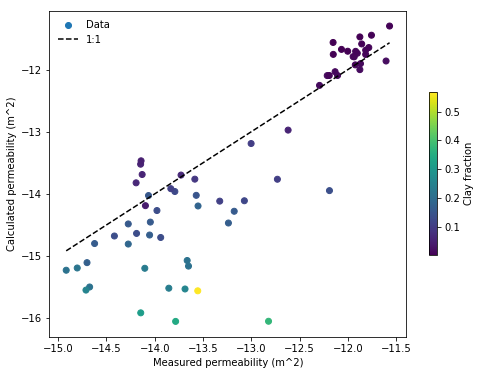

In [12]:
fig, ax = pl.subplots(1, 1, figsize=(8, 6))
sc = ax.scatter(np.log10(df['permeability_measured']), np.log10(df['k_calculated']), c=df['clay_fraction'])

l11 = ax.plot(klims, klims, ls='--', color='black')

cb = fig.colorbar(sc, shrink=0.5)
cb.set_label('Clay fraction')

ax.set_xlabel('Measured permeability (m^2)')
ax.set_ylabel('Calculated permeability (m^2)')

ax.legend([sc, l11[0]], ['Data', '1:1'], loc='upper left', frameon=False)

fn1 = os.path.split(fn)[-1][:-4]
fn2 = fn1 + '_measured_vs_calculated_k.%s' % figure_extension
fig_fn = os.path.join('figs', fn2)
print('saving figure as ', fig_fn)
fig.savefig(fig_fn, dpi=300)

**Fig caption** *Measurred vs calculated permeability using the power mean of the permeability of the granular and clay fractions*

### Normalized difference of measured permeability and the theoretical permeability of the granular and clay fractions

In [13]:
# calculate k offset using clay composition estimates for datasets
df['k_offset'] = \
    (np.log10(df['permeability_measured']) - np.log10(df['k_clay'])) / \
    (np.log10(df['k_granular']) - np.log10(df['k_clay']))

In [14]:
# load permeability vs clay content model Revil (2002)
dfr = pd.read_csv('data/simulated_k_revil1999_model.csv')

saving figure as  figs/porperm_data_well_AST02_with_spec_surf_normalized_k.png


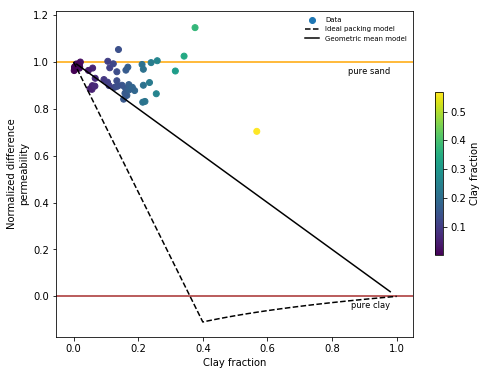

In [15]:
fig, ax = pl.subplots(1, 1, figsize=(8, 6))

# plot data
sc = ax.scatter(df['clay_fraction'], df['k_offset'], c=df['clay_fraction'])

# plot theoretical geometric mean k of clay and sand fractions in panel d
w_plot = np.arange(0.01, 0.99, 0.01)
k0 = 1
k1 = 10
geom_mean = power_mean(0.0, w_plot, k0, k1)
leg_dfg, = ax.plot(w_plot, np.log10(geom_mean), color='black', ls='-')
leg_dfm, = ax.plot(dfr['cv'], dfr['k_normalized_Knoll1996'], color='black', ls='--')

# add lines for theoretical permeability pure granular or clay components
xmax = 1.0
leg_k_sd = ax.axhline(y=1, color='orange', ls='-', lw=1.5, zorder=0)
leg_k_cl = ax.axhline(y=0, color='brown', ls='-', lw=1.5, zorder=0)
ax.text(xmax - 0.02, 0.98, 'pure sand',
          fontsize='small', ha='right', va='top')
ax.text(xmax - 0.02, -0.02, 'pure clay',
          fontsize='small', ha='right', va='top')

# add a colorbar
cb = fig.colorbar(sc, shrink=0.5)
cb.set_label('Clay fraction')

ax.set_xlabel('Clay fraction')
ax.set_ylabel('Normalized difference\npermeability')

# add a legend:
legs = [sc, leg_dfm, leg_dfg]
labels = ['Data', 
          'Ideal packing model',
          'Geometric mean model']
legend = ax.legend(legs, labels,
                   fontsize='x-small',
                   ncol=1, numpoints=1, loc='upper right', frameon=False)


# save figure
fn1 = os.path.split(fn)[-1][:-4]
fn2 = fn1 + '_normalized_k.%s' % figure_extension
fig_fn = os.path.join('figs', fn2)
print('saving figure as ', fig_fn)
fig.savefig(fig_fn, dpi=300)

**Fig. caption** *Normalized permeability of the permeability dataset compared to two theoretical models, 1) the ideal packing model (Revil 1999, 2002) and 2) the geometric mean model. This is a simplified version of Fig. 5 in Luijendijk & Gleeson (2015)*